[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edwinRNDR/micro-workshop-photo-viz/blob/master/notebooks/map-images.ipynb)

Notebook for mapping images using CLIP and tSNE.

Uses https://github.com/openai/clip to obtain image features.

Uses https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html to reduce the number of dimensions from 512 to 2

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-r4hye0iv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-r4hye0iv
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=e16156c6d9935c24b5fdeaff1d177a9825388bcb4585b1b1dea692dfbd32277e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hhbbaql1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
import clip

In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 219MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f2fbd6e9990>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [12]:
import glob
from PIL import Image
import os.path

images = []
image_names = []
for file_name in glob.glob("images/*.jpg"):
  image = Image.open(file_name).convert("RGB")
  images.append(preprocess(image))
  image_names.append(os.path.basename(file_name))

In [10]:
image_input = torch.tensor(np.stack(images)).cuda()
image_features = []
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [11]:
image_features

tensor([[ 0.2009, -0.0428,  0.2773,  ..., -0.1464, -0.6304, -0.0055],
        [ 0.1434, -0.1169, -0.0284,  ...,  0.4958, -0.0685,  0.0695],
        [ 0.4333, -0.0839,  0.1884,  ..., -0.0024, -0.1216,  0.2323],
        ...,
        [ 0.1951, -0.0159,  0.0291,  ...,  0.5654, -0.0293, -0.2133],
        [ 0.4575,  0.3357,  0.0820,  ...,  0.5273, -0.3552, -0.2559],
        [ 0.0403, -0.2761,  0.1637,  ...,  0.0940, -0.1494, -0.0996]],
       device='cuda:0')

In [17]:
norm_image_features = image_features / image_features.norm(dim=-1, keepdim=True)

In [19]:
features = norm_image_features.cpu().numpy()
features
features.shape

(100, 512)

Write features to CSV

In [32]:
import pandas as pd
df = pd.DataFrame(features)
df["filename"] = image_names
# reorder columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.to_csv("image-features.csv", index=False)

We now have a set of 512 dimensional image descriptors. Let's see if we can reduce the 512 dimensions to 2. 

To do this we using a technique called TSNE, which is provided by the sklearn library.

In [40]:
from sklearn.manifold import TSNE
import pandas as pd

prompt_logits_path = "image-features.csv"
features_df = pd.read_csv(prompt_logits_path)
print(features_df.shape)

tsne = TSNE(n_components=2, perplexity=25, learning_rate=10)
embed = tsne.fit_transform(features_df[features_df.columns[1:]])
embed = embed.reshape(features_df.shape[0],2)

embed_df = pd.DataFrame(embed)
embed_df["filename"] = image_names
cols = embed_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
embed_df = embed_df[cols]
embed_df.to_csv("image-tsne.csv", index=False)


(100, 513)


Quickly visualize the two 2 dimensional embedding

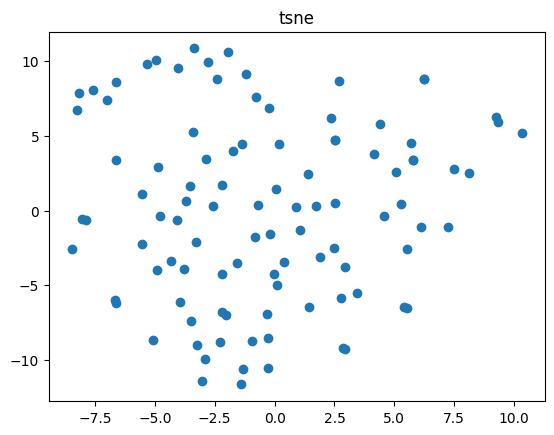

In [39]:
import matplotlib.pyplot as plt

plt.scatter(embed[:,0], embed[:,1])
plt.title("tsne")
plt.show()